In [ ]:
!pip install torch_geometric

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx

courses = {
    'ENG EK 125': {'prerequisites': [], 'skills': ['Mathematical Skills', 'Problem Solving']},
    'ENG EK 210': {'prerequisites': ['ENG EK 125'], 'skills': ['Engineering Fundamentals', 'Technical Writing']},
    'ENG ME 231': {'prerequisites': ['ENG EK 210'], 'skills': ['Mechanical Engineering Skills', 'Design Skills']},
    'ENG EC 327': {'prerequisites': ['ENG EK 125'], 'skills': ['Embedded Systems', 'Programming Skills']},
    'ENG EC 464': {'prerequisites': ['ENG EC 327'], 'skills': ['Digital Signal Processing', 'Advanced Programming']},
    'ENG BE 403': {'prerequisites': ['ENG EK 125'], 'skills': ['Biomedical Engineering Principles', 'Analytical Skills']},
    'ENG SE 501': {'prerequisites': ['ENG EK 210'], 'skills': ['Systems Engineering Concepts', 'Modeling Skills']},

    'CAS CS 111': {'prerequisites': [], 'skills': ['Mathematical Skills', 'Introductory Programming', 'Algorithmic Thinking']},
    'CAS CS 112': {'prerequisites': ['CAS CS 111'], 'skills': ['Data Structures', 'Algorithmic Thinking']},
    'CAS CS 210': {'prerequisites': ['CAS CS 112'], 'skills': ['Computer Systems', 'Programming Skills']},
    'CAS CS 330': {'prerequisites': ['CAS CS 210'], 'skills': ['Theory of Computation', 'Problem Solving']},
    'CAS CS 455': {'prerequisites': ['CAS CS 330'], 'skills': ['Machine Learning', 'Data Analysis']},
    'CAS CS 460': {'prerequisites': ['CAS CS 210'], 'skills': ['Data Visualization', 'Information Design']},
    'CAS CS 411': {'prerequisites': ['CAS CS 210'], 'skills': ['Software Engineering', 'Project Management']},
    'CAS CS 440': {'prerequisites': ['CAS CS 210'], 'skills': ['Artificial Intelligence', 'Problem Solving']},

    'CAS EC 101': {'prerequisites': [], 'skills': ['Economic Theory', 'Analytical Skills']},
    'CAS EC 102': {'prerequisites': [], 'skills': ['Economic Theory', 'Critical Thinking']},
    'CAS EC 201': {'prerequisites': ['CAS EC 101', 'CAS MA 123'], 'skills': ['Microeconomics', 'Quantitative Analysis']},
    'CAS EC 202': {'prerequisites': ['CAS EC 102', 'CAS MA 124'], 'skills': ['Macroeconomics', 'Analytical Skills']},
    'CAS EC 320': {'prerequisites': ['CAS EC 201'], 'skills': ['Econometrics', 'Data Analysis']},
    'CAS EC 414': {'prerequisites': ['CAS EC 320'], 'skills': ['Behavioral Economics', 'Policy Analysis']},

    'CAS PS 101': {'prerequisites': [], 'skills': ['Psychological Concepts', 'Critical Thinking']},
    'CAS PS 231': {'prerequisites': ['CAS PS 101'], 'skills': ['Developmental Psychology', 'Research Skills']},
    'CAS PS 241': {'prerequisites': ['CAS PS 101'], 'skills': ['Social Psychology', 'Interpersonal Skills']},
    'CAS PS 371': {'prerequisites': ['CAS PS 241'], 'skills': ['Cognitive Psychology', 'Analytical Skills']},
    'CAS PS 332': {'prerequisites': ['CAS PS 231'], 'skills': ['Neuroscience', 'Analytical Thinking']},

    'CAS PH 100': {'prerequisites': [], 'skills': ['Philosophical Thinking', 'Ethical Reasoning']},
    'CAS PH 110': {'prerequisites': [], 'skills': ['Logic', 'Analytical Thinking']},
    'CAS PH 150': {'prerequisites': [], 'skills': ['Ethics', 'Moral Reasoning']},
    'CAS PH 245': {'prerequisites': ['CAS PH 100'], 'skills': ['Philosophy of Mind', 'Critical Analysis']},
    'CAS PH 260': {'prerequisites': ['CAS PH 110'], 'skills': ['Epistemology', 'Logical Reasoning']},
    'CAS PH 300': {'prerequisites': ['CAS PH 150'], 'skills': ['Metaphysics', 'Abstract Thinking']}
}


skill_categories_to_jobs = {
    'Mathematical Skills': ['Data Analyst', 'Engineer', 'Actuary'],
    'Problem Solving': ['Engineer', 'Consultant', 'Data Scientist'],
    'Engineering Fundamentals': ['Mechanical Engineer', 'Project Manager'],
    'Technical Writing': ['Technical Writer', 'Project Manager'],
    'Mechanical Engineering Skills': ['Mechanical Engineer', 'Robotics Engineer'],
    'Design Skills': ['Product Designer', 'Mechanical Engineer'],
    'Embedded Systems': ['Embedded Software Engineer', 'Robotics Engineer'],
    'Digital Signal Processing': ['Signal Processing Engineer', 'Software Developer'],
    'Biomedical Engineering Principles': ['Biomedical Engineer', 'Clinical Engineer'],
    'Systems Engineering Concepts': ['Systems Engineer', 'Operations Analyst'],

    'Introductory Programming': ['Software Developer', 'IT Support Specialist'],
    'Algorithmic Thinking': ['Software Engineer', 'Data Scientist'],
    'Data Structures': ['Software Engineer', 'Systems Analyst'],
    'Computer Systems': ['Systems Engineer', 'Software Developer'],
    'Theory of Computation': ['Software Engineer', 'Computational Scientist'],
    'Machine Learning': ['Machine Learning Engineer', 'Data Scientist'],
    'Data Analysis': ['Data Analyst', 'Business Intelligence Analyst'],
    'Data Visualization': ['Data Visualization Specialist', 'UI/UX Designer'],
    'Programming Skills': ['Software Developer', 'Data Scientist'],
    'Software Engineering': ['Software Engineer', 'DevOps Engineer'],
    'Project Management': ['Project Manager', 'Product Manager'],
    'Artificial Intelligence': ['AI Researcher', 'Machine Learning Engineer'],

    'Economic Theory': ['Economic Consultant', 'Policy Analyst'],
    'Critical Thinking': ['Policy Analyst', 'Researcher'],
    'Microeconomics': ['Financial Analyst', 'Economic Consultant'],
    'Macroeconomics': ['Policy Analyst', 'Economic Consultant'],
    'Quantitative Analysis': ['Data Analyst', 'Financial Analyst'],
    'Econometrics': ['Econometrician', 'Data Scientist'],
    'Policy Analysis': ['Policy Analyst', 'Economic Researcher'],
    'Behavioral Economics': ['Behavioral Economist', 'Market Research Analyst'],
}

G = nx.DiGraph()

for course in courses:
    G.add_node(course, layer=0)

for skill_category in skill_categories_to_jobs:
    G.add_node(skill_category, layer=1)

for jobs in skill_categories_to_jobs.values():
    for job in jobs:
        G.add_node(job, layer=2)

for course, details in courses.items():
    for prereq in details['prerequisites']:
        if prereq in G:
            G.add_edge(prereq, course, relationship='prerequisite')

for course, details in courses.items():
    for skill in details['skills']:
        if skill in G:
            G.add_edge(course, skill, relationship='course_to_skill')

for skill_category, jobs in skill_categories_to_jobs.items():
    for job in jobs:
        if job in G:
            G.add_edge(skill_category, job, relationship='skill_to_job')

for node in G.nodes:
    if 'layer' not in G.nodes[node]:
        print(f"Node {node} is missing the 'layer' attribute")

node_mapping = {node: idx for idx, node in enumerate(G.nodes)}

edges = [(node_mapping[u], node_mapping[v]) for u, v in G.edges]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

node_features = torch.eye(len(G.nodes))

data = Data(x=node_features, edge_index=edge_index)

print("Graph data ready for training!")

Graph data ready for training!


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN(input_dim=len(G.nodes), hidden_dim=16, output_dim=len(G.nodes))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    target = torch.randint(0, len(G.nodes), (len(G.nodes),), dtype=torch.long)
    loss = F.nll_loss(out, target)
    loss.backward()
    optimizer.step()
    return loss.item()

for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss}")

model.eval()
output = model(data)
predicted_classes = output.argmax(dim=1)
print("Predicted classes:", predicted_classes)

Epoch 0, Loss: 4.579655170440674
Epoch 10, Loss: 4.5756378173828125
Epoch 20, Loss: 4.602993965148926
Epoch 30, Loss: 4.585259437561035
Epoch 40, Loss: 4.581970691680908
Epoch 50, Loss: 4.582065105438232
Epoch 60, Loss: 4.5879807472229
Epoch 70, Loss: 4.594422340393066
Epoch 80, Loss: 4.579429626464844
Epoch 90, Loss: 4.593581676483154
Predicted classes: tensor([ 8,  8, 23, 31, 23, 23, 23, 42, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23,  8, 23, 23,  8, 42,  8, 23, 23,
        23, 23, 23, 23, 23, 23, 42, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 10,
        23, 23, 23, 23, 23, 23, 10, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 10, 10, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 10, 23, 23, 23, 10, 23, 23])


In [ ]:
def suggest_next_steps(current_courses=[], current_skills=[]):
    next_courses = set()
    next_skills = set()
    next_jobs = set()

    for course in current_courses:
        if course in G:
            for neighbor in G.neighbors(course):
                if G.nodes[neighbor]['layer'] == 1:
                    next_skills.add(neighbor)
                elif G.nodes[neighbor]['layer'] == 0:
                    next_courses.add(neighbor)

    for skill in current_skills:
        if skill in G:
            for neighbor in G.neighbors(skill):
                if G.nodes[neighbor]['layer'] == 2:
                    next_jobs.add(neighbor)

    return {
        'next_courses': list(next_courses),
        'next_skills': list(next_skills),
        'next_jobs': list(next_jobs)
    }

current_courses = ['ENG EK 125', 'CAS CS 111']
current_skills = ['Programming Skills']

suggestions = suggest_next_steps(current_courses, current_skills)

print("Based on your current status:")
print(f"Next possible courses: {suggestions['next_courses']}")
print(f"Next possible skills to develop: {suggestions['next_skills']}")
print(f"Potential career paths: {suggestions['next_jobs']}")


Based on your current status:
Next possible courses: ['ENG EC 327', 'ENG EK 210', 'CAS CS 112', 'ENG BE 403']
Next possible skills to develop: ['Introductory Programming', 'Problem Solving', 'Algorithmic Thinking', 'Mathematical Skills']
Potential career paths: ['Software Developer', 'Data Scientist']


In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

SelectMultiple(description='Courses:', options=('CAS CS 111', 'CAS CS 112', 'CAS CS 210', 'CAS CS 330', 'CAS C…

SelectMultiple(description='Skills:', options=('Algorithmic Thinking', 'Artificial Intelligence', 'Behavioral …

SelectMultiple(description='Jobs:', options=('AI Researcher', 'Actuary', 'Behavioral Economist', 'Biomedical E…

Button(description='Get Suggestions', style=ButtonStyle())


Based on your current academic, skill, and job status:
Next possible courses: ['CAS CS 411', 'CAS CS 455', 'CAS CS 460', 'CAS CS 440', 'CAS CS 112', 'CAS CS 210', 'CAS CS 330']
Skills you can develop: ['Computer Systems', 'Algorithmic Thinking', 'Introductory Programming', 'Theory of Computation', 'Data Structures', 'Programming Skills', 'Problem Solving', 'Mathematical Skills']
Potential career paths: ['Behavioral Economist', 'Market Research Analyst', 'Machine Learning Engineer', 'AI Researcher']


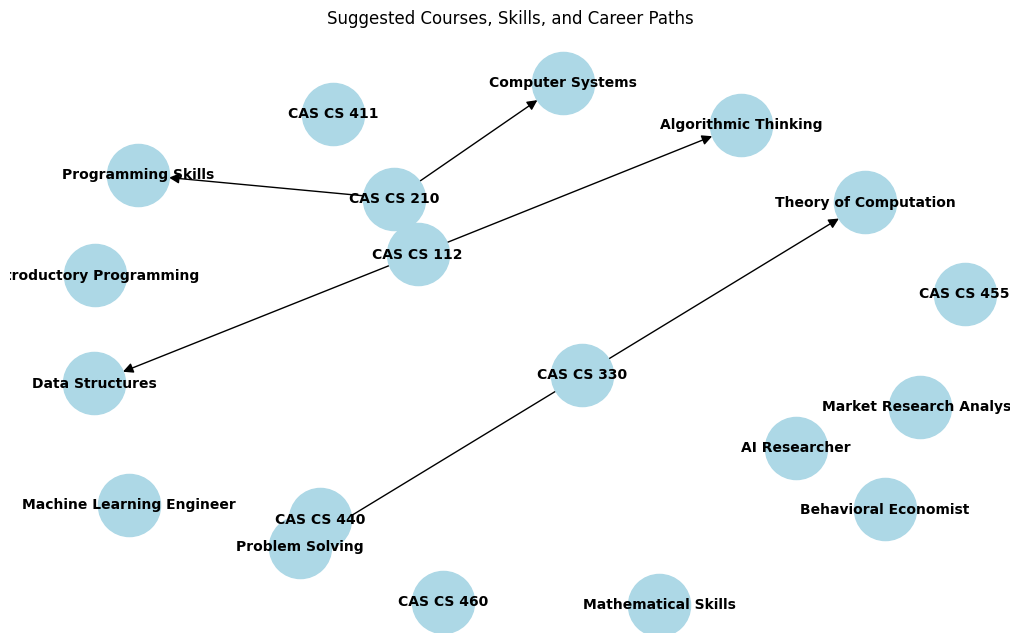

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def build_and_display_graph(suggestions):
    G = nx.DiGraph()

    for course in suggestions['next_courses']:
        G.add_node(course, layer='Course')
    for skill in suggestions['next_skills']:
        G.add_node(skill, layer='Skill')
    for job in suggestions['next_jobs']:
        G.add_node(job, layer='Job')

    for course in suggestions['next_courses']:
        if course in courses:
            for skill in courses[course]['skills']:
                if skill in suggestions['next_skills']:
                    G.add_edge(course, skill)

    for skill in suggestions['next_skills']:
        if skill in skill_categories_to_jobs:
            for job in skill_categories_to_jobs[skill]:
                if job in suggestions['next_jobs']:
                    G.add_edge(skill, job)

    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 6))
    nx.draw(
        G, pos, with_labels=True, node_size=2000, node_color='lightblue',
        font_size=10, font_weight='bold', arrows=True, arrowstyle='-|>', arrowsize=15
    )
    plt.title("Suggested Courses, Skills, and Career Paths")
    plt.show()

def display_suggestions(courses, skills, jobs):
    suggestions = suggest_next_steps(current_courses=courses, current_skills=skills)
    print("\nBased on your current academic, skill, and job status:")
    print(f"Next possible courses: {suggestions['next_courses']}")
    print(f"Skills you can develop: {suggestions['next_skills']}")
    print(f"Potential career paths: {suggestions['next_jobs']}")
    if jobs:
        print(f"Selected jobs: {jobs}")

    build_and_display_graph(suggestions)

all_courses = sorted(courses.keys())
all_skills = sorted(skill_categories_to_jobs.keys())
all_jobs = sorted(set(job for jobs in skill_categories_to_jobs.values() for job in jobs))

course_selector = widgets.SelectMultiple(options=all_courses, description='Courses:', disabled=False)
skill_selector = widgets.SelectMultiple(options=all_skills, description='Skills:', disabled=False)
job_selector = widgets.SelectMultiple(options=all_jobs, description='Jobs:', disabled=False)

suggest_button = widgets.Button(description="Get Suggestions")

def on_suggest_button_clicked(b):
    selected_courses = list(course_selector.value)
    selected_skills = list(skill_selector.value)
    selected_jobs = list(job_selector.value)
    display_suggestions(selected_courses, selected_skills, selected_jobs)

suggest_button.on_click(on_suggest_button_clicked)

display(course_selector, skill_selector, job_selector, suggest_button)

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')
print("Model weights saved to model_weights.pth")

Model weights saved to model_weights.pth
